In [ ]:
import numpy as np  # Para operaciones numéricas
import torch  # Para trabajar con PyTorch
import torch.nn as nn  # Para redes neuronales
from torch.utils.data import DataLoader, Dataset

# Importación de librerías necesarias
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import timedelta

# Asegúrate de definir la clase GlobalLSTM antes de usarla
class GlobalLSTM(nn.Module):
    def __init__(self,
                 num_stores,   # total de tiendas
                 num_depts,    # total de deptos
                 emb_dim_store=4,
                 emb_dim_dept=8,
                 num_numeric_features=15,
                 hidden_size=64,
                 num_layers=1,
                 dropout=0.2):
        super().__init__()

        # Embeddings para las variables categóricas
        self.store_emb = nn.Embedding(num_stores, emb_dim_store)
        self.dept_emb = nn.Embedding(num_depts, emb_dim_dept)

        # Dimensión total de entrada al LSTM
        self.input_dim = emb_dim_store + emb_dim_dept + num_numeric_features

        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, X_cat, X_num):
        """
        X_cat: tensor de tamaño [batch, seq_length, 3] con [Store_id, Dept_id, Type_id]
        X_num: tensor de tamaño [batch, seq_length, num_numeric_features]
        """
        store_id = X_cat[:, :, 0].long()
        dept_id = X_cat[:, :, 1].long()

        store_emb_out = self.store_emb(store_id)
        dept_emb_out = self.dept_emb(dept_id)

        # Concatenar embeddings y variables numéricas
        concat_input = torch.cat([store_emb_out, dept_emb_out, X_num], dim=-1)
        lstm_out, _ = self.lstm(concat_input)
        last_out = lstm_out[:, -1, :]  # Tomamos el último paso de la secuencia
        out = self.fc(last_out)
        return out.squeeze(-1)

# Luego, define las variables necesarias para la instanciación
num_stores = 45  # Por ejemplo, el número de tiendas
num_depts = 81   # Por ejemplo, el número de departamentos

# Crea una instancia del modelo
model_loaded = GlobalLSTM(
    num_stores=num_stores,
    num_depts=num_depts,
    emb_dim_store=4,
    emb_dim_dept=8,
    num_numeric_features=15,
    hidden_size=64,
    num_layers=1,
    dropout=0.2
)

# Cargar los pesos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_loaded.load_state_dict(torch.load('modelo_demanda.pth', map_location=device))

# Mueve el modelo al dispositivo
model_loaded.to(device)

GlobalLSTM(
  (store_emb): Embedding(45, 4)
  (dept_emb): Embedding(81, 8)
  (lstm): LSTM(27, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Ingrese el ID de la tienda (código numérico): 4
Ingrese el ID del departamento (código numérico): 34

Predicciones:
 Store_id  Dept_id  Week_Ahead  Predicted_Weekly_Sales
        4       34           1            26163.427734
        4       34           2             8598.880859
        4       34           3             8192.333984
        4       34           4             9317.567383


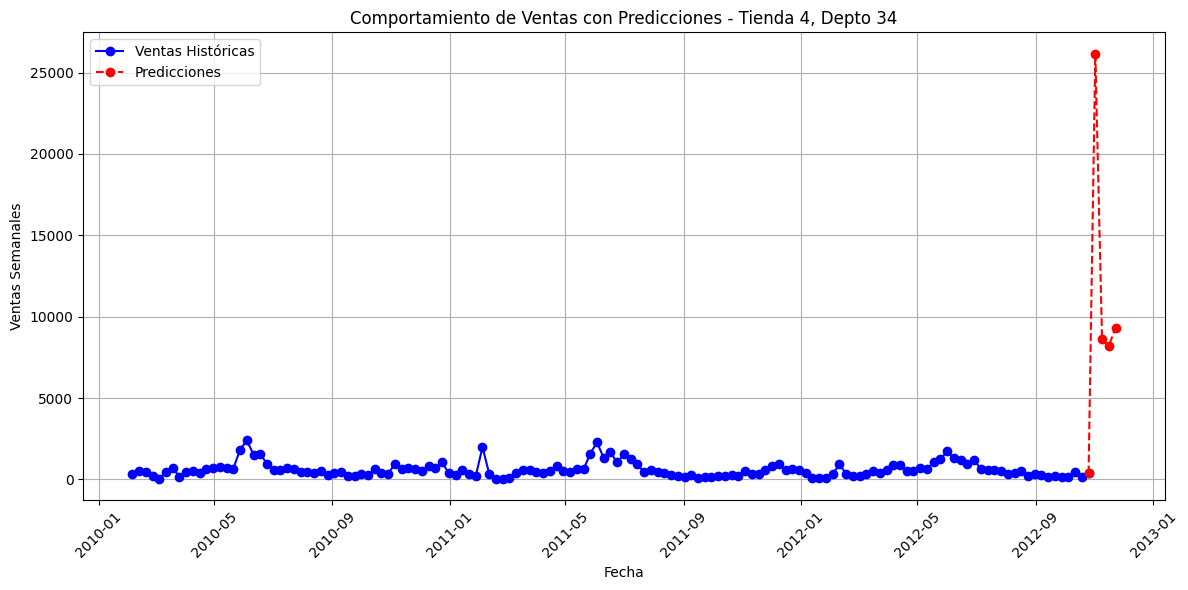

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings('ignore')

# === 1. Carga y Preprocesamiento de Datos ===
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df[df['Weekly_Sales'] > 0]
    df.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)
    df.fillna(method='ffill', inplace=True)


    # Crear variables temporales
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfYear'] = df['Date'].dt.dayofyear

    # Convertir IsHoliday a entero (0/1)
    df["IsHoliday"] = df["IsHoliday"].astype(int)

    # Codificar variables categóricas
    store_encoder = LabelEncoder()
    dept_encoder = LabelEncoder()


    df['Store_id'] = store_encoder.fit_transform(df['Store'])
    df['Dept_id'] = dept_encoder.fit_transform(df['Dept'])


    # Variables numéricas para escalado y entrada
    # Aquí se escalan algunas variables; se deja IsHoliday sin escalar
    num_cols = [
        'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
        'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
        'Year', 'Month', 'Week', 'DayOfYear', 'IsHoliday'
    ]


    # Escalado de las variables (excepto IsHoliday)
    max_dia = df['Date'].max()
    test_start_date = max_dia - pd.Timedelta(weeks=12)

    train_df = df[df['Date'] < test_start_date]
    test_df = df[df['Date'] >= test_start_date]


    scaler = MinMaxScaler()
    train_df[num_cols[:-1]] = scaler.fit_transform(train_df[num_cols[:-1]])  # No escalar IsHoliday
    test_df[num_cols[:-1]] = scaler.transform(test_df[num_cols[:-1]])



    # Puedes decidir si incluir 'IsHoliday' en la entrada numérica o tratarlo aparte.
    # En este ejemplo, supondré que el modelo fue entrenado con las 9 variables de num_cols.

    return df, train_df, test_df,num_cols

# === 2. Definir la Función de Predicción ===
def predict_future_weeks(model, df, store_id, dept_id, cat_cols, num_cols,
                         seq_length=8, forecast_horizon=4, device='cpu'):
    """
    Predice las ventas de las próximas 'forecast_horizon' semanas para la tienda y depto indicados.
    """
    preds = []

    # Filtrar datos para la tienda y departamento seleccionados
    sub_df = df[(df['Store_id'] == store_id) & (df['Dept_id'] == dept_id)].sort_values('Date')
    if len(sub_df) < seq_length:
        raise ValueError(f"No hay suficientes datos para la tienda {store_id} y depto {dept_id}.")

    # Extraer la secuencia inicial
    last_seq = sub_df.iloc[-seq_length:].copy()
    # Extraer variables categóricas y numéricas con la forma adecuada: [1, seq_length, features]
    X_cat = last_seq[cat_cols].values[np.newaxis, :, :]
    X_num = last_seq[num_cols].values[np.newaxis, :, :]

    X_cat_t = torch.tensor(X_cat, dtype=torch.float32).to(device)
    X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)


    model.eval()
    with torch.no_grad():
        for week_ahead in range(forecast_horizon):
            # Realiza la predicción para la semana actual
            pred = model(X_cat_t, X_num_t).cpu().item()

            preds.append({
                'Store_id': store_id,
                'Dept_id': dept_id,
                'Week_Ahead': week_ahead + 1,
                'Predicted_Weekly_Sales': pred
            })

            # Actualiza la secuencia para la siguiente predicción
            new_cat = X_cat_t.cpu().numpy()[0, -1, :]  # Última fila de variables categóricas
            last_num = X_num_t.cpu().numpy()[0, -1, :]  # Última fila numérica
            new_num = np.append(last_num[1:], pred)  # Desplazar y añadir la predicción

            # Combinar y actualizar las secuencias
            new_X_cat = np.vstack([X_cat_t.cpu().numpy()[0, 1:, :], new_cat])
            new_X_num = np.vstack([X_num_t.cpu().numpy()[0, 1:, :], new_num])

            X_cat_t = torch.tensor(new_X_cat, dtype=torch.float32).unsqueeze(0).to(device)
            X_num_t = torch.tensor(new_X_num, dtype=torch.float32).unsqueeze(0).to(device)



    return pd.DataFrame(preds)

# === 3. Cargar Modelo y Datos Preprocesados ===
if __name__ == '__main__':
    # Configurar dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Cargar el modelo (asegúrate de que la ruta sea la correcta)

    model_loaded.load_state_dict(torch.load('modelo_demanda.pth', map_location=device))

    # Mueve el modelo al dispositivo
    model_loaded.to(device)
    model_loaded.eval()


    # Cargar y preprocesar los datos
    data_path = 'sales_data (1).csv'
    df, train_df, test_df, num_cols = load_and_preprocess_data(data_path)


    # Definir las columnas que se usan en la entrada del modelo
    # Para las variables categóricas, en este ejemplo usamos: Store_id y Dept_id.
    cat_cols = ['Store_id', 'Dept_id']
    # Para las variables numéricas, usamos las mismas que se escalaron (9 variables)
    # Si en el entrenamiento se incluyó 'IsHoliday' u otra, asegúrate de ser consistente.

    # === 4. Interfaz para el Usuario ===
    # El usuario solo debe ingresar el ID de la tienda y el departamento
    store_id_input = int(input("Ingrese el ID de la tienda (código numérico): "))
    dept_id_input = int(input("Ingrese el ID del departamento (código numérico): "))




    # Realizar la predicción
    forecast_horizon = 4  # Por ejemplo, predecir 4 semanas en el futuro que serían casi 30 días aproximadamente
    future_pred_df = predict_future_weeks(model_loaded, df, store_id_input, dept_id_input,
                                            cat_cols, num_cols, seq_length=8,
                                            forecast_horizon=forecast_horizon, device=device)

    print("\nPredicciones:")
    # Usando pandas para mostrar la tabla de manera estilizada
    pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
    pd.set_option('display.width', None)  # No truncar el ancho de las columnas
    print(future_pred_df.to_string(index=False))  # Imprimir sin índice

    import matplotlib.pyplot as plt
import pandas as pd

def plot_sales_with_predictions(df, future_pred_df, store_id, dept_id):
    # Filtrar los datos históricos de la tienda y departamento seleccionados
    sub_df = df[(df['Store_id'] == store_id) & (df['Dept_id'] == dept_id)].sort_values('Date')

    # Asegurar que 'Date' sea tipo datetime
    sub_df['Date'] = pd.to_datetime(sub_df['Date'])

    # Crear un DataFrame para las predicciones que incluya el último punto histórico
    last_historical_date = sub_df['Date'].iloc[-1]
    last_historical_value = sub_df['Weekly_Sales'].iloc[-1]

    # Crear fechas de predicción
    pred_dates = [last_historical_date] + [
        last_historical_date + pd.Timedelta(weeks=i)
        for i in range(1, len(future_pred_df) + 1)
    ]

    # Crear valores de predicción que incluyan el último valor histórico
    pred_values = [last_historical_value] + future_pred_df['Predicted_Weekly_Sales'].tolist()

    # Crear DataFrame de predicciones actualizado
    predictions_df = pd.DataFrame({
        'Date': pred_dates,
        'Predicted_Weekly_Sales': pred_values
    })

    # Graficar
    plt.figure(figsize=(12, 6))

    # Graficar datos históricos
    plt.plot(sub_df['Date'], sub_df['Weekly_Sales'],
             label="Ventas Históricas", color="blue", marker="o")

    # Graficar predicciones incluyendo el punto de conexión
    plt.plot(predictions_df['Date'], predictions_df['Predicted_Weekly_Sales'],
             label="Predicciones", color="red", linestyle="--", marker="o")

    # Configurar la gráfica
    plt.title(f"Comportamiento de Ventas con Predicciones - Tienda {store_id}, Depto {dept_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas Semanales")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Uso de la función
if __name__ == '__main__':
    plot_sales_with_predictions(df, future_pred_df, store_id_input, dept_id_input)

Ingrese el Store ID: 5
Ingrese el Dept ID: 42
Evaluación del modelo en test:
MAE: 327.15
MSE: 168641.87


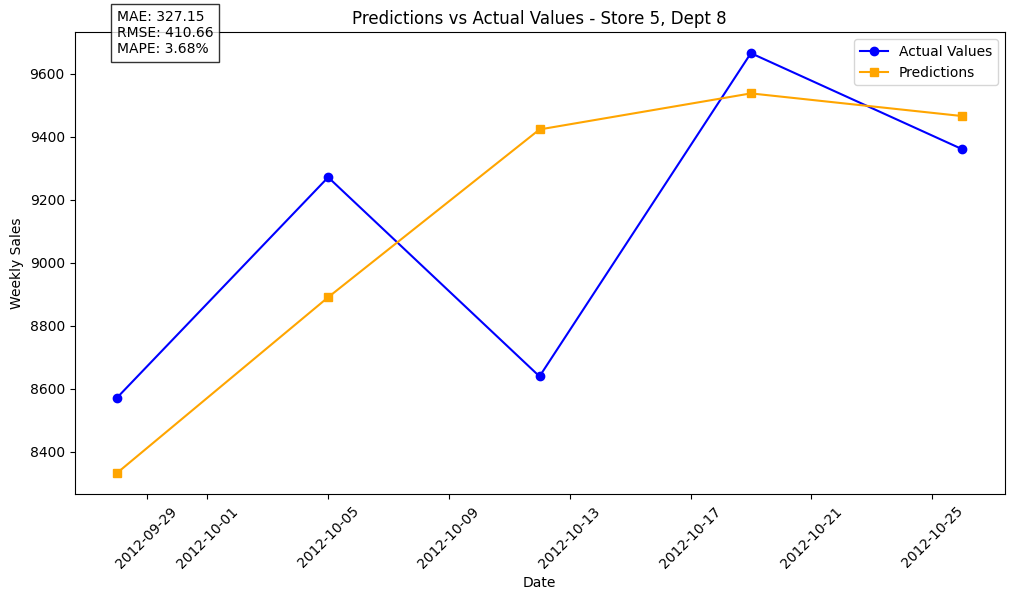

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings('ignore')

# === 1. Carga y Preprocesamiento de Datos ===
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df[df['Weekly_Sales'] > 0]
    df.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)
    df.fillna(method='ffill', inplace=True)


    # Crear variables temporales
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfYear'] = df['Date'].dt.dayofyear

    # Convertir IsHoliday a entero (0/1)
    df["IsHoliday"] = df["IsHoliday"].astype(int)

    # Codificar variables categóricas
    store_encoder = LabelEncoder()
    dept_encoder = LabelEncoder()


    df['Store_id'] = store_encoder.fit_transform(df['Store'])
    df['Dept_id'] = dept_encoder.fit_transform(df['Dept'])


    # Variables numéricas para escalado y entrada
    # Aquí se escalan algunas variables; se deja IsHoliday sin escalar
    num_cols = [
        'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
        'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
        'Year', 'Month', 'Week', 'DayOfYear', 'IsHoliday'
    ]


    # Escalado de las variables (excepto IsHoliday)
    max_dia = df['Date'].max()
    test_start_date = max_dia - pd.Timedelta(weeks=12)

    train_df = df[df['Date'] < test_start_date]
    test_df = df[df['Date'] >= test_start_date]


    scaler = MinMaxScaler()
    train_df[num_cols[:-1]] = scaler.fit_transform(train_df[num_cols[:-1]])  # No escalar IsHoliday
    test_df[num_cols[:-1]] = scaler.transform(test_df[num_cols[:-1]])

    print(train_df.head())



    # Puedes decidir si incluir 'IsHoliday' en la entrada numérica o tratarlo aparte.
    # En este ejemplo, supondré que el modelo fue entrenado con las 9 variables de num_cols.

    return df, train_df, test_df,num_cols

def evaluate_model_on_test(model_loaded, test_df, cat_cols, num_cols, seq_length=8, device='cpu'):
    """
    Evalúa el modelo en el conjunto de prueba, prediciendo semana a semana.
    Retorna un DataFrame con predicciones y calcula el error.
    """
    test_predictions = []

    store_id = int(input("Ingrese el Store ID: "))
    dept_id = int(input("Ingrese el Dept ID: "))

    sub_df = test_df[(test_df['Store_id'] == store_id) & (test_df['Dept_id'] == dept_id)].sort_values('Date')

    if len(sub_df) < seq_length:
        print("No hay suficientes datos para la predicción.")
        return pd.DataFrame()

    for i in range(len(sub_df) - seq_length):
        # Obtener la secuencia de entrada
        last_seq = sub_df.iloc[i:i + seq_length]
        X_cat = last_seq[cat_cols].values[np.newaxis, :, :]
        X_num = last_seq[num_cols].values[np.newaxis, :, :]

        # Convertir a tensores
        X_cat_t = torch.tensor(X_cat, dtype=torch.float32).to(device)
        X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)

        # Obtener predicción
        model_loaded.eval()
        with torch.no_grad():
            pred = model_loaded(X_cat_t, X_num_t).item()

        # Registrar predicción con fecha real de la semana
        true_value = sub_df.iloc[i + seq_length]['Weekly_Sales']
        date_value = sub_df.iloc[i + seq_length]['Date']

        test_predictions.append({
            'Store_id': store_id,
            'Dept_id': dept_id,
            'Date': date_value,
            'Predicted_Weekly_Sales': pred,
            'Actual_Weekly_Sales': true_value
        })

    pred_df = pd.DataFrame(test_predictions)

    # Calcular métricas de error
    mae = mean_absolute_error(pred_df['Actual_Weekly_Sales'], pred_df['Predicted_Weekly_Sales'])
    mse = mean_squared_error(pred_df['Actual_Weekly_Sales'], pred_df['Predicted_Weekly_Sales'])

    print(f"Evaluación del modelo en test:\nMAE: {mae:.2f}\nMSE: {mse:.2f}")

    return pred_df

# Evaluar el modelo en el conjunto de prueba
test_pred_df = evaluate_model_on_test(model_loaded, test_df, cat_cols, num_cols, seq_length=8, device=device)

if not test_pred_df.empty:
    # Asegurar que la fecha es tipo datetime
    test_pred_df['Date'] = pd.to_datetime(test_pred_df['Date'])

    # Graficar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(test_pred_df['Date'], test_pred_df['Actual_Weekly_Sales'], marker='o', linestyle='-', label="Actual Values", color='blue')
    plt.plot(test_pred_df['Date'], test_pred_df['Predicted_Weekly_Sales'], marker='s', linestyle='-', label="Predictions", color='orange')

    # Agregar etiquetas y título
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.title(f"Predictions vs Actual Values - Store {store_id}, Dept {dept_id}")
    plt.legend()

    # Calcular métricas MAE, RMSE y MAPE
    actual_values = test_pred_df['Actual_Weekly_Sales'].values
    predicted_values = test_pred_df['Predicted_Weekly_Sales'].values

    mae = abs(actual_values - predicted_values).mean()
    rmse = ((actual_values - predicted_values) ** 2).mean() ** 0.5
    mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100

    # Mostrar métricas en un cuadro de texto
    textstr = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%'
    plt.text(test_pred_df['Date'].iloc[0], max(actual_values), textstr, bbox=dict(facecolor='white', alpha=0.8))

    # Rotar las fechas para mejor visualización
    plt.xticks(rotation=45)

    # Mostrar la gráfica
    plt.show()






